In [15]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
# from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import cv2
import pandas as pd

In [47]:
source = 'detection_test_results_2018-07-25'
verbose = False

In [91]:
# Loop through tests, loading results into lists of dictionaries
tests = ['test1', 'test2', 'test3', 'test4']
tests_short = ['Test 1', 'Test 2', 'Test 3', 'Test 4']

models = ['ssd_mobilenet_v1_coco',
          'ssd_mobilenet_v2_coco',
          'ssdlite_mobilenet_v2_coco',
          'ssd_inception_v2_coco',
          'faster_rcnn_inception_v2_coco',
          'faster_rcnn_resnet50_coco',
          'faster_rcnn_resnet50_lowproposals_coco',
          'faster_rcnn_resnet101_coco',
          'faster_rcnn_resnet101_lowproposals_coco',
          'mask_rcnn_inception_v2_coco']

models_old = ['ssd_mobilenet_v1_coco',
              'sd_mobilenet_v2_coco',
              'ssdlite_mobilenet_v2_coco',
              'ssd_inception_v2_coco',
              'faster_rcnn_inception_v2_coco',
              'faster_rcnn_resnet50_coco',
              'faster_rcnn_resnet50_lowproposals_coco',
              'faster_rcnn_resnet101_coco',
              'faster_rcnn_resnet101_lowproposals_coco',
              'mask_rcnn_inception_v2_coco']

models_short = ['SSD_Mobilenet_v1',
          'SSD_Mobilenet_v2',
          'SSDlite_Mobilenet_v2',
          'SSD_Inception_v2',
          'F_RCNN_Inception_v2',
          'F_RCNN_Resnet50',
          'F_RCNN_Resnet50_LP',
          'F_RCNN_Resnet101',
          'F_RCNN_Resnet101_LP',
          'Mask_RCNN_Inception_v2']

In [49]:
gt_path = 'detections.csv'

with open(gt_path, 'r') as f:
  reader = csv.reader(f)
  gt_raw = list(reader)
    
def fill_blanks(_item):
    if _item is '':
        return 0
    return int(_item)

gts = []
for test in tests:
    if verbose:
        print('\n\t> {}'.format(test))
    gt = []
    for g in gt_raw[1:]:  # ignore header
        if g[0] == test:
            result = [fill_blanks(r) for r in g[1:]]
            gt.append(result)
            if verbose:
                print(result)
    gts.append(gt)

In [50]:
np.shape(gts)

(4, 100, 5)

In [51]:
# extract results
results = []
for test in tests:
    if verbose:
        print('\n> {}'.format(test))
    test_results = []
    for model in models:
        if verbose:
            print('\t> {}'.format(model))
        path = os.path.join(source, test + '_' + model + '.npy')
        model_results = np.load(path)
        if verbose:
            print('\t\t> {} detections'.format(len(model_results)))
        test_results.append(model_results)
    results.append(test_results)

In [52]:
# calculate detection rate TP/(TP+FN)
# model
#    test
#        frame

all_detection_rate_results = []
all_av_detection_rate_results = []
model_summary = []

for m, model in enumerate(models):

    detection_rate_results = []
    av_detection_rate_results = []

    for test, test_gt, test_results in zip(tests, gts, results):
        if verbose:
            print('\n\t>{}'.format(test))

        test_gt_full = []
        test_gt_partial = []
        test_gt_heavy = []
        test_gt_all = []
        
        test_detections = []
        test_detection_full = []
        test_detection_partial = []
        test_detection_heavy = []
        
        test_detection_rates = []
        test_detection_rates_full = []
        test_detection_rates_partial = []
        test_detection_rates_heavy = []

        model_results = test_results[m]
        if verbose:
            print('> Model: {}'.format(model))

        for gt in test_gt:

            gt_full = int(gt[2])
            gt_partial = int(gt[3])
            gt_heavy = int(gt[4])
            gt_all = int(gt[2]) + int(gt[3]) + int(gt[4])
            
            true_possitives = 0
            if gt_all:  # ignores empty frames
                # Check for all results with same frame id
                for model_result in model_results:
                    if int(model_result[0]) == int(gt[1]):
                        true_possitives += 1

                test_gt_all.append(gt_all)
                test_gt_full.append(gt_full)
                test_gt_partial.append(gt_partial)
                test_gt_heavy.append(gt_heavy)
                
                detection_full = min(true_possitives, gt_full)
                detection_partial = min(true_possitives - detection_full, gt_partial)
                detection_heavy = min(true_possitives - detection_full - detection_partial, gt_heavy)
                
                test_detections.append(true_possitives)
                test_detection_full.append(detection_full)
                test_detection_partial.append(detection_partial)
                test_detection_heavy.append(detection_heavy)
                
                test_detection_rates.append(true_possitives/gt_all)
                test_detection_rates_full.append(detection_full/gt_all)
                test_detection_rates_partial.append(detection_partial/gt_all)
                test_detection_rates_heavy.append(detection_heavy/gt_all)
                
            if verbose:
                print('{} gt detection > {} model detections'.format(gt_all, true_possitives))

        if test_gt_all:
            test_gt_all = np.array(test_gt_all)
            test_gt_full = np.array(test_gt_full)
            test_gt_partial = np.array(test_gt_partial)
            test_gt_heavy = np.array(test_gt_heavy)
            
            test_detections = np.array(test_detections)
            test_detection_full = np.array(test_detection_full)
            test_detection_partial = np.array(test_detection_partial)
            test_detection_heavy = np.array(test_detection_heavy)
            
            test_detection_rates = np.array(test_detection_rates)
            test_detection_rates_full = np.array(test_detection_rates_full)
            test_detection_rates_partial = np.array(test_detection_rates_partial)
            test_detection_rates_heavy = np.array(test_detection_rates_heavy) 
            
            test_detection_rate_results = (test_gt_all, test_detections, test_detection_rates)
            
            av_detection_rate_all = sum(test_detections) / sum(test_gt_all)
            av_detection_rate_full = sum(test_detection_full) / sum(test_gt_all)
            av_detection_rate_partial = sum(test_detection_partial) / sum(test_gt_all)
            av_detection_rate_heavy = sum(test_detection_heavy) / sum(test_gt_all)
            
            test_av_det_rate_results = (av_detection_rate_all, av_detection_rate_full, av_detection_rate_partial, av_detection_rate_heavy)
            
            detection_rate_results.append(test_detection_rate_results)
            av_detection_rate_results.append(test_av_det_rate_results)
            
    model_summary.append(sum(test_detections) / sum(test_gt_all))
            
    all_detection_rate_results.append(detection_rate_results)
    all_av_detection_rate_results.append(av_detection_rate_results)
 

In [53]:
model_summary

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [54]:
# Consider detection rates by frame
all_detection_rate_results_1 = all_detection_rate_results[:5]
all_detection_rate_results_2 = all_detection_rate_results[5:]

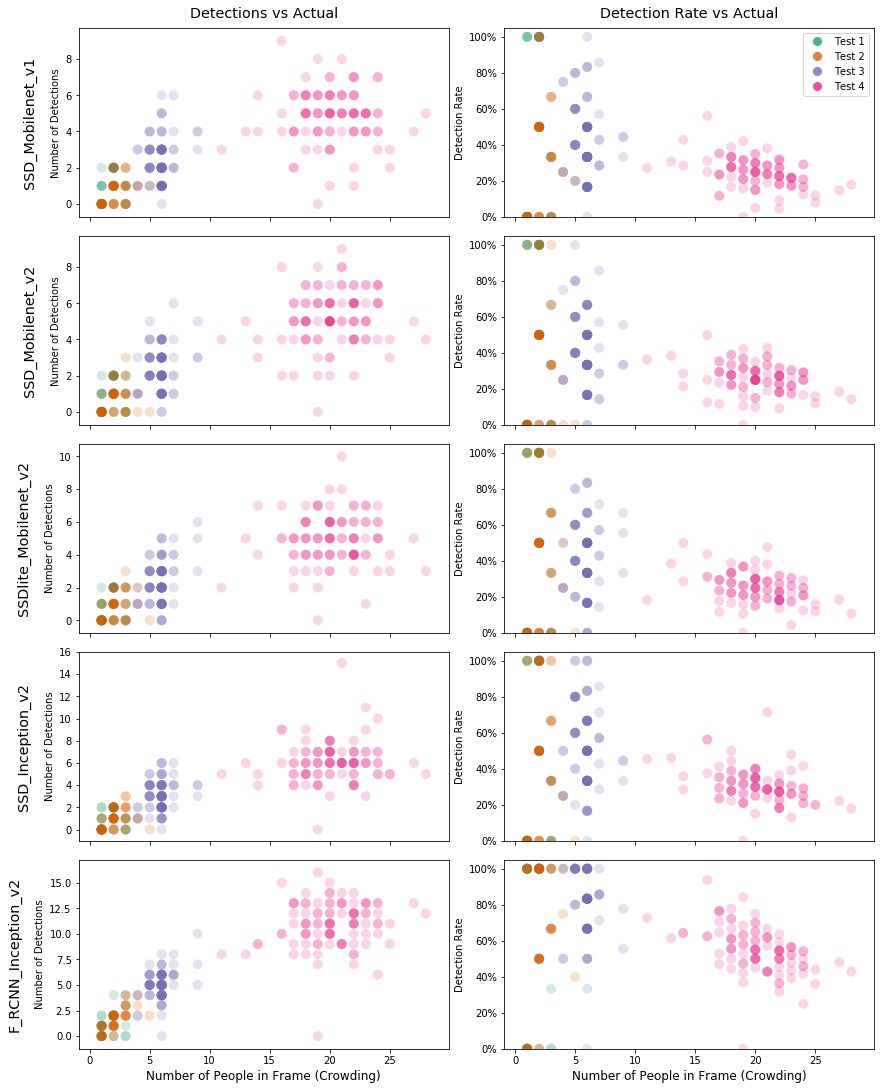

In [59]:
selection = all_detection_rate_results_1
# colours = ("blue", "orange", "grey", "green")
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

titles = ['Detections vs Actual', 'Detection Rate vs Actual']
cols = 2
rows = len(selection)
fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 3*rows))                        
for row, detection_rate_results in enumerate(selection):
    for detection_rate_result, color, test in zip(detection_rate_results, colours, tests):
        x, y1, y2 = detection_rate_result
        axes[row,0].scatter(x, y1, alpha=0.2, c=color, edgecolors='none', s=100, label=test)
        axes[row,1].scatter(x, y2, alpha=0.2, c=color, edgecolors='none', s=100, label=test)          
        axes[row,0].set_ylabel('Number of Detections')
        axes[row,1].set_ylim([0, 1.05])
        vals = axes[row,1].get_yticks()
        axes[row,1].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        axes[row,1].set_ylabel('Detection Rate')
axes[-1,0].set_xlabel('Number of People in Frame (Crowding)', size='large')
axes[-1,1].set_xlabel('Number of People in Frame (Crowding)', size='large')
pad = 10
for ax, title in zip(axes[0], titles):
    ax.annotate(title, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')
for ax, model in zip(axes[:,0], models_short):
    ax.annotate(model, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)
    
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label=test,
                          markerfacecolor=colours[t], alpha = 0.8, markersize=10) for t, test in enumerate(tests_short)]
axes[0,1].legend(handles=legend_elements, loc=1)

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.1)
plt.show()

In [60]:
fig.savefig('figures/5_3a.png', bbox_inches='tight')

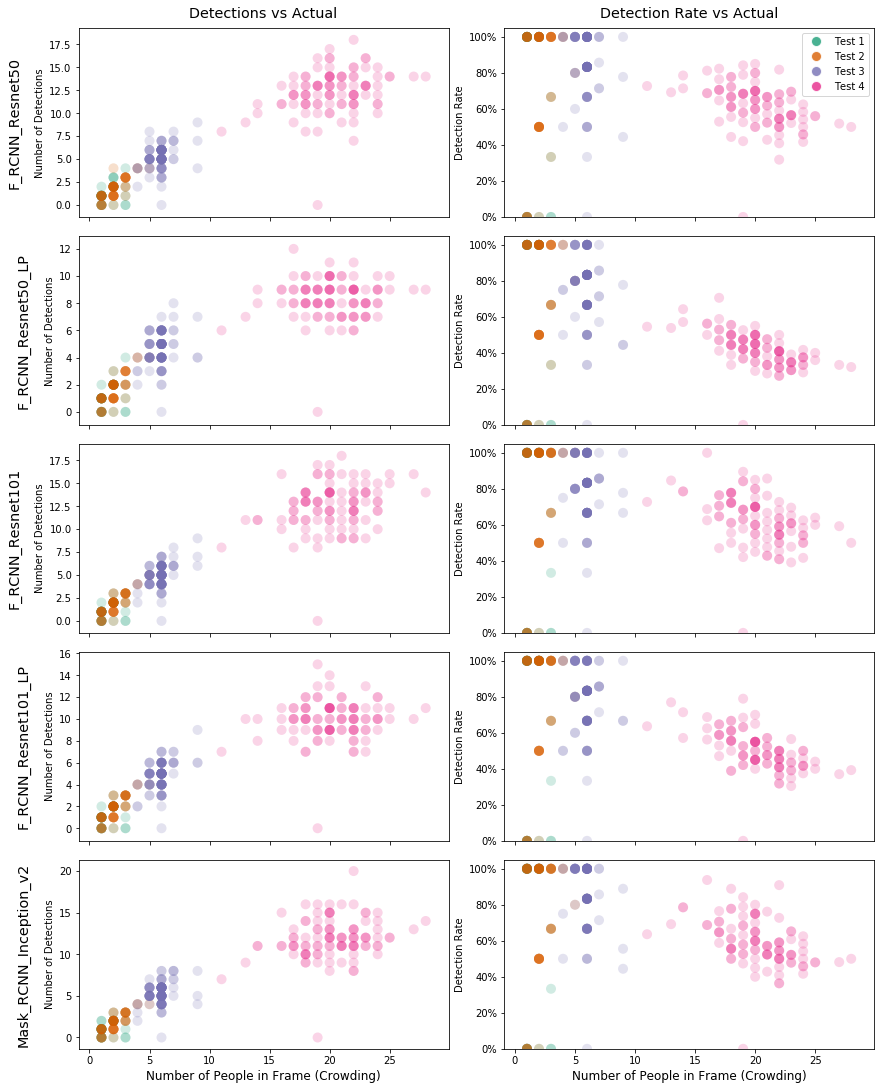

In [61]:
selection = all_detection_rate_results_2
# colours = ("blue", "orange", "grey", "green")
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

titles = ['Detections vs Actual', 'Detection Rate vs Actual']
cols = 2
rows = len(selection)
fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 3*rows))                        
for row, detection_rate_results in enumerate(selection):
    for detection_rate_result, color, test in zip(detection_rate_results, colours, tests):
        x, y1, y2 = detection_rate_result
        axes[row,0].scatter(x, y1, alpha=0.2, c=color, edgecolors='none', s=100, label=test)
        axes[row,1].scatter(x, y2, alpha=0.2, c=color, edgecolors='none', s=100, label=test)          
        axes[row,0].set_ylabel('Number of Detections')
        axes[row,1].set_ylim([0, 1.05])
        vals = axes[row,1].get_yticks()
        axes[row,1].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        axes[row,1].set_ylabel('Detection Rate')
axes[-1,0].set_xlabel('Number of People in Frame (Crowding)', size='large')
axes[-1,1].set_xlabel('Number of People in Frame (Crowding)', size='large')
pad = 10
for ax, title in zip(axes[0], titles):
    ax.annotate(title, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')
for ax, model in zip(axes[:,0], models_short[-5:]):
    ax.annotate(model, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)
    
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label=test,
                          markerfacecolor=colours[t], alpha = 0.8, markersize=10) for t, test in enumerate(tests_short)]
axes[0,1].legend(handles=legend_elements, loc=1)

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.1)
plt.show()

In [62]:
fig.savefig('figures/5_3b.png', bbox_inches='tight')

In [63]:
model_summary

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [64]:
# Calculate detection rates at different occlusions

In [65]:
test_results = []
for t, test in enumerate(tests):
    model_results = []
    for model, model_result in zip(models_short, all_av_detection_rate_results):     
        test_result = model_result[t]
        model_results.append(test_result[0])
    test_results.append(model_results)
np.shape(test_results)

(4, 10)

In [66]:
d = {k: i for (k, i) in zip(tests, test_results)}
d['model'] = models_short
d['test_average'] = model_summary
df = pd.DataFrame(data=d)
df.set_index('model')
df

,model,test1,test2,test3,test4,test_average
0,SSD_Mobilenet_v1,0.490196,0.336283,0.404762,0.238991,0.238991
1,SSD_Mobilenet_v2,0.509804,0.353982,0.403061,0.256309,0.256309
2,SSDlite_Mobilenet_v2,0.490196,0.389381,0.404762,0.244433,0.244433
3,SSD_Inception_v2,0.509804,0.451327,0.518707,0.300841,0.300841
4,F_RCNN_Inception_v2,0.764706,0.734513,0.853741,0.540821,0.540821
5,F_RCNN_Resnet50,0.803922,0.823009,0.889456,0.609599,0.609599
6,F_RCNN_Resnet50_LP,0.745098,0.796460,0.794218,0.412667,0.412667
7,F_RCNN_Resnet101,0.725490,0.858407,0.848639,0.618011,0.618011
8,F_RCNN_Resnet101_LP,0.725490,0.849558,0.819728,0.490846,0.490846
9,Mask_RCNN_Inception_v2,0.745098,0.831858,0.904762,0.586343,0.586343


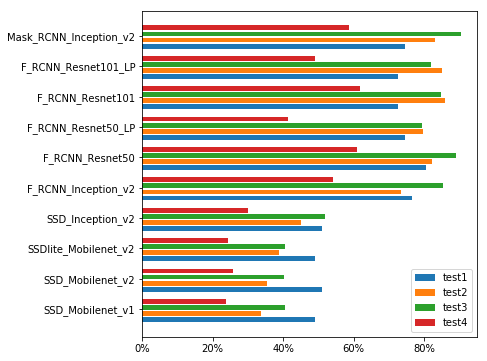

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))
ind = np.arange(10)    # the x locations for the groups
width = 0.16
spacing = 0.2
axes.barh(ind, df.test1, width, label=tests[0])
axes.barh(ind + spacing, df.test2, width, label=tests[1])
axes.barh(ind + (2*spacing), df.test3, width, label=tests[2])
axes.barh(ind + (3* spacing), df.test4, width, label=tests[3])

axes.set_yticks(ind + 0.34)
axes.set_yticklabels(df.model)
vals = axes.get_xticks()
axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
axes.legend()

plt.show()

In [68]:
# Consider by test

In [69]:
df_results = []
headers = ['none', 'partial', 'heavy']
for t, test in enumerate(tests):
    model_results = []
    full = []
    partial = []
    heavy = []
    for model, model_result in zip(models_short, all_av_detection_rate_results):     
        test_result = model_result[t]
        full.append(test_result[1])
        partial.append(test_result[2])
        heavy.append(test_result[3])
    all_results = (full, partial, heavy)
    d = {k: i for (k, i) in zip(headers, all_results)}
    d['model'] = models_short
    df = pd.DataFrame(data=d)
    df.set_index('model')
    df_results.append(df)


In [70]:
df_results[0]

,heavy,model,none,partial
0,0.058824,SSD_Mobilenet_v1,0.333333,0.078431
1,0.078431,SSD_Mobilenet_v2,0.333333,0.078431
2,0.078431,SSDlite_Mobilenet_v2,0.313725,0.078431
3,0.058824,SSD_Inception_v2,0.333333,0.078431
4,0.215686,F_RCNN_Inception_v2,0.372549,0.078431
5,0.235294,F_RCNN_Resnet50,0.372549,0.098039
6,0.215686,F_RCNN_Resnet50_LP,0.372549,0.098039
7,0.235294,F_RCNN_Resnet101,0.372549,0.078431
8,0.235294,F_RCNN_Resnet101_LP,0.372549,0.078431
9,0.215686,Mask_RCNN_Inception_v2,0.372549,0.098039


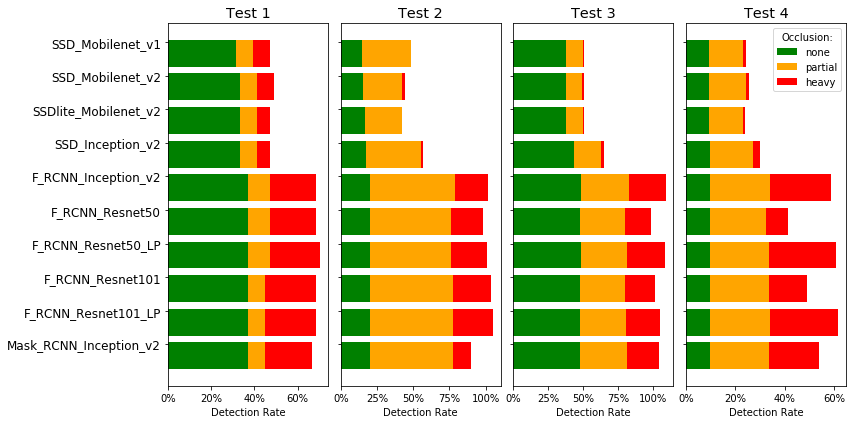

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=len(tests), sharey=True, figsize=(12,6))
ind = np.arange(10)    # the x locations for the groups
width = 0.16
spacing = 0.2
for col, (t, df_result, test_short) in enumerate(zip(tests, df_results, tests_short)):
    axes[col].barh(df_result.model, df_result.none, label=headers[0], color='green')
    axes[col].barh(df_result.model, df_result.partial, label=headers[1], left=df_result.none, color='orange')
    axes[col].barh(df_result.model, df_result.heavy, label=headers[2], left=df_result.partial + df_result.none, color='red')

    axes[col].set_yticks(ind + 0.34)
    axes[col].set_yticklabels(df_result.model[::-1], size='large')
    vals = axes[col].get_xticks()
    axes[col].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    axes[col].set_xlabel('Detection Rate')
    axes[col].set_title(test_short, size='x-large')
axes[-1].legend(['none', 'partial', 'heavy'], title="Occlusion:")

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.08, hspace=0)
plt.show()

In [73]:
fig.savefig('figures/5_4.png', bbox_inches='tight')

In [74]:
test_results[1]

[0.336283185840708,
 0.35398230088495575,
 0.3893805309734513,
 0.45132743362831856,
 0.7345132743362832,
 0.8230088495575221,
 0.7964601769911505,
 0.8584070796460177,
 0.8495575221238938,
 0.831858407079646]

In [75]:
test_results[2]

[0.40476190476190477,
 0.4030612244897959,
 0.40476190476190477,
 0.5187074829931972,
 0.8537414965986394,
 0.8894557823129252,
 0.79421768707483,
 0.8486394557823129,
 0.8197278911564626,
 0.9047619047619048]

In [76]:
test_results[3]

[0.23899059871350817,
 0.25630875804057396,
 0.24443344878772885,
 0.3008411677387432,
 0.5408213755566551,
 0.6095992083127165,
 0.4126669965363681,
 0.6180108857001484,
 0.49084611578426524,
 0.5863433943592281]

In [77]:
results

[[array([[ 1.48070000e+04, -1.00000000e+00,  2.85230970e+02,
           1.91429257e+00,  1.19041443e+02,  2.78143959e+02,
           5.81134200e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48170000e+04, -1.00000000e+00,  4.14272861e+02,
           0.00000000e+00,  6.99636841e+01,  1.33313749e+02,
           5.40454507e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48400000e+04, -1.00000000e+00,  1.02390118e+02,
           1.83256459e+02,  4.08203487e+02,  3.50819163e+02,
           8.46546948e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48480000e+04, -1.00000000e+00,  6.41261029e+01,
           7.83187866e+00,  1.43389814e+02,  3.33856423e+02,
           8.10304999e-01, -1.00000000e+00, -1.00000000e+00,
          -1.00000000e+00],
         [ 1.48810000e+04, -1.00000000e+00,  6.99774055e+02,
           8.92193270e+01,  1.80297089e+02,  4.42203290e+02,
           7.95615017e-01, -1.0000

In [78]:
# Consider locations

all_centre_results = []

for m, model in enumerate(models):
    if verbose:
            print('\n\t>{}'.format(model))
    
    model_centre_results = []
    
    for test, test_results in zip(tests, results):
        model_results = test_results[m]
        if verbose:
            print('\n>{}'.format(test))
        
        test_centre_x = []
        test_centre_y = []
        test_conf = []

        for result in model_results:
            # <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>
            left, top, width, height, conf = result[2:7]
            test_centre_x.append(int(left + (width/2)))
            test_centre_y.append(int(top + (height/2)))
            test_conf.append(int(conf*100))
            
        if verbose:
            print('{} centres found'.format(len(model_centre_x)))
            
        if test_centre_x:
            test_centre_x = np.array(test_centre_x)
            test_centre_y = np.array(test_centre_y)
            test_conf = np.array(test_conf)
            model_centre_results.append((test_centre_x, test_centre_y, test_conf))
            
    all_centre_results.append(model_centre_results)


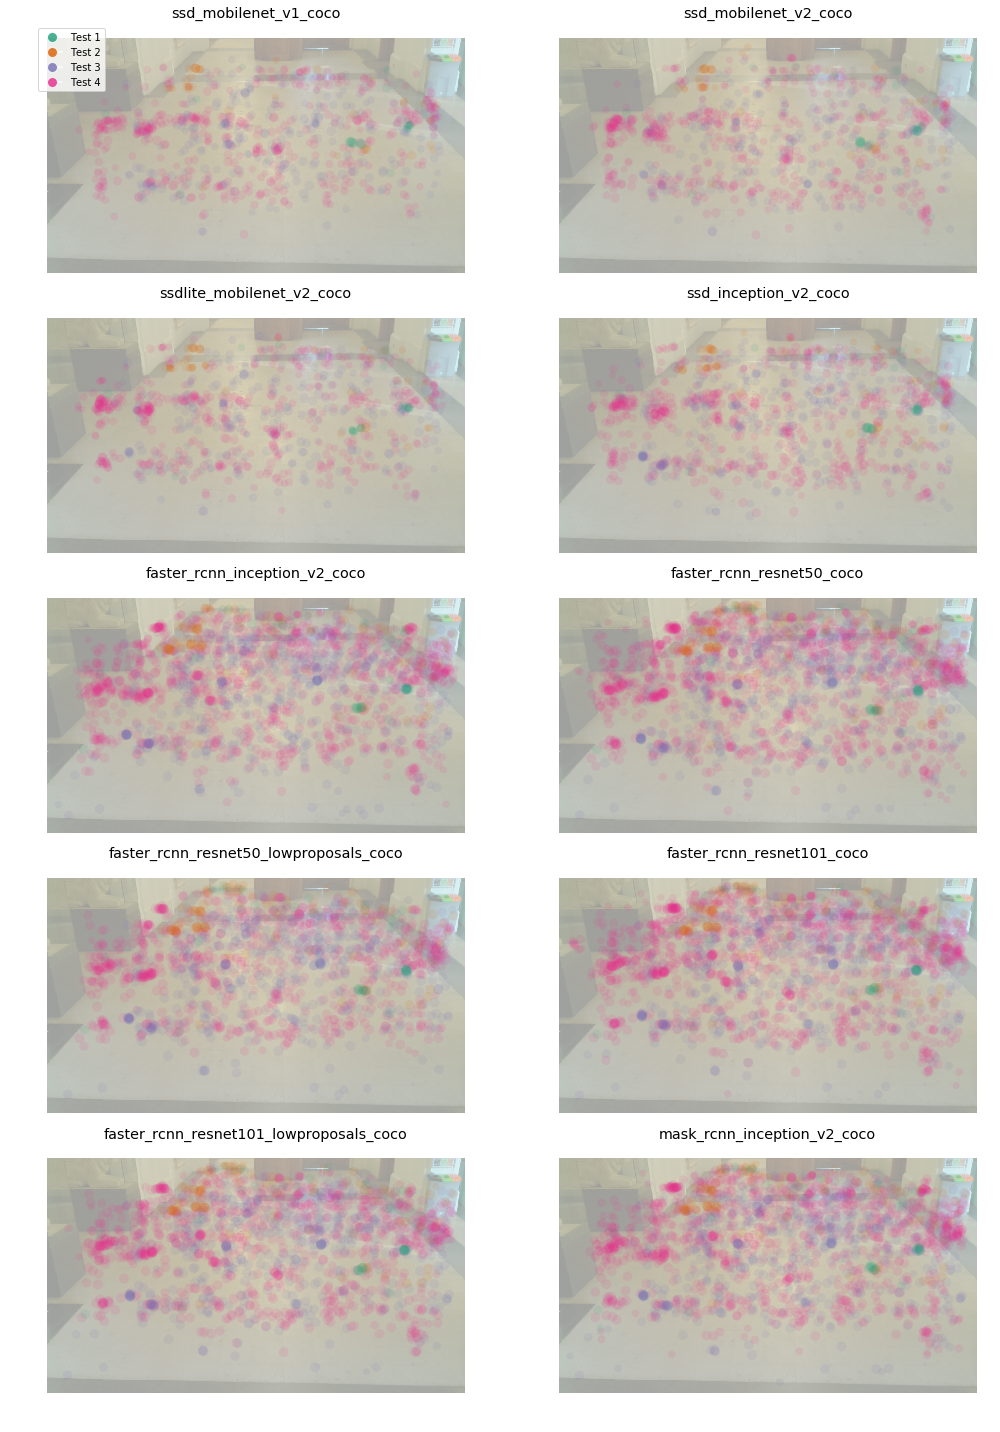

In [83]:
# colours = ("blue", "orange", "grey", "green")
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 100


titles = ['Detections']

cols = 2
rows = int(len(all_centre_results) / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(14, 4*rows))

for row in range(rows):
    for col in range(cols):
        index = (row * cols) + col
        model = models[index]
        model_centre_results = all_centre_results[index]
        axes[row,col].imshow(frame)
        for test, colour, test_centre_results in zip(reversed(tests), reversed(colours), reversed(model_centre_results)):
            x, y, c = test_centre_results
            axes[row,col].scatter(x, y, alpha=0.1, c=colour, edgecolors='none', s=c, label=test)
            axes[row, col].set_title(model, size='x-large')
            axes[row, col].axis('off')
            
legend_elements = [Line2D([0], [0], marker='o', color='w', label=test,
                          markerfacecolor=colours[t], alpha = 0.8, markersize=10) for t, test in enumerate(tests_short)]
axes[0,0].legend(handles=legend_elements, loc=2)

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.06)

plt.show()

In [84]:
fig.savefig('figures/5_5.png', bbox_inches='tight')

In [85]:
# Unpack performance results
performance_paths = ['performance_test1.npy',
                     'performance_test2.npy',
                     'performance_test3.npy',
                     'performance_test4.npy', ]
all_performance = []
for perf_path in performance_paths:
    performance = np.load(os.path.join(source, perf_path))[()]
    all_performance.append(performance)

In [86]:
for v in all_performance[0].items():
    print(v)

('ssd_mobilenet_v1_coco', {'triggers': 44, 'av_time': 0.18693213636363637})
('sd_mobilenet_v2_coco', {'triggers': 44, 'av_time': 0.2726270681818182})
('ssdlite_mobilenet_v2_coco', {'triggers': 44, 'av_time': 0.19238611363636363})
('ssd_inception_v2_coco', {'triggers': 44, 'av_time': 0.36078372727272723})
('faster_rcnn_inception_v2_coco', {'triggers': 44, 'av_time': 1.8930659772727274})
('faster_rcnn_resnet50_coco', {'triggers': 44, 'av_time': 5.525509045454545})
('faster_rcnn_resnet50_lowproposals_coco', {'triggers': 44, 'av_time': 2.9677958409090905})
('faster_rcnn_resnet101_coco', {'triggers': 44, 'av_time': 7.349114318181818})
('faster_rcnn_resnet101_lowproposals_coco', {'triggers': 44, 'av_time': 4.86589625})
('mask_rcnn_inception_v2_coco', {'triggers': 44, 'av_time': 10.452249477272726})


In [87]:
np.shape(all_av_detection_rate_results)

(10, 4, 4)

In [88]:
all_av_detection_rate_results[0][0]

(0.49019607843137253,
 0.3333333333333333,
 0.0784313725490196,
 0.058823529411764705)

In [89]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
colours2 = cm.rainbow(np.linspace(0,1,10))

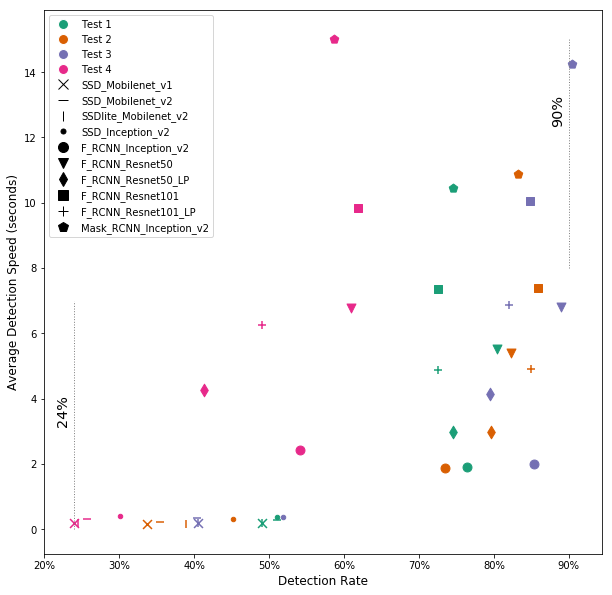

In [120]:
symbols = ["x", "_", "|", ".", "o", "v", "d", "s", "+", "p"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

axes.plot([0.24,0.24],[0,7],'k-', linestyle = ":", lw=1, color = 'grey')
axes.annotate('24%', xy=(0, 0), xytext=(25, 100),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)
axes.plot([0.9,0.9],[8,15],'k-', linestyle = ":", lw=1, color = 'grey')
axes.annotate('90%', xy=(0, 0), xytext=(520, 400),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)

for m, (model, test_result) in enumerate(zip(models_old, all_av_detection_rate_results)):
    for t, (test, model_result) in enumerate(zip(tests, test_result)):
        av_detection_rate = model_result[0]
        test_perf = all_performance[t]
        model_perf = test_perf[model]['av_time']
        
        axes.scatter(av_detection_rate, model_perf, c=colours[t], marker=symbols[m], s=80)
        axes.set_xlabel('Detection Rate', size='large')
        axes.set_ylabel('Average Detection Speed (seconds)', size='large')
        vals = axes.get_xticks()
        axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
        legend_elements = legend_elements + [Line2D([0], [0], marker=mark, color='w', markeredgecolor='black', label=mmap,markerfacecolor='black',
                                       markersize=10) for mark, mmap in zip(symbols, models_short)]
        
        axes.legend(handles=legend_elements)
        

plt.show()

In [121]:
fig.savefig('figures/5_6.png', bbox_inches='tight')